In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path=("/content/drive/MyDrive/dataset/spam.csv")

In [3]:
#Importing necessary pre-processing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, pad_sequences
from keras.callbacks import EarlyStopping
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
%matplotlib inline

In [27]:
df=pd.read_csv(path,encoding = "ISO-8859-1")

# **Analysing the Dataset**

In [28]:
df.shape

(5572, 5)

In [29]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [31]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


# **Data Preprocessing**

In [32]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [33]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Text(0, 0.5, 'Number of Data points')

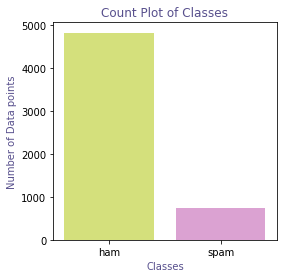

In [34]:
#Palette
cols= ["#E1F16B", "#E598D8"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(4,4))
sns.countplot(x= df['label'], palette= cols)
plt.title("Count Plot of Classes", color="#58508d")
plt.xlabel("Classes", color="#58508d")
plt.ylabel("Number of Data points", color="#58508d")

Data is imbalanced.

86.6 % are "ham" messages and remaining 13.4 % are "spam" messages

# **Train-test split**

In [47]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split
  
X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [48]:
# Tokenizer
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = keras.utils.pad_sequences(sequences,maxlen=max_len)

# **Build The Model-LSTM**

In [49]:
# Build The model
# model = Sequential()
# model.add(embedding_layer)
# model.add(Dropout(0.2))
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))

In [50]:
inputs = Input(name='inputs',shape=[max_len])
layer = Embedding(max_words,50,input_length=max_len)(inputs)
layer = LSTM(64)(layer)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,name='out_layer')(layer)
layer = Activation('sigmoid')(layer)

In [51]:
model = Model(inputs=inputs,outputs=layer)

In [52]:
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [53]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
28/28 [==============================] - 14s 415ms/step - loss: 0.3214 - accuracy: 0.8724 - val_loss: 0.1553 - val_accuracy: 0.9563
Epoch 2/10
28/28 [==============================] - 7s 267ms/step - loss: 0.0943 - accuracy: 0.9781 - val_loss: 0.0557 - val_accuracy: 0.9843


# **Test the Model**

In [54]:
#processing test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = keras.utils.pad_sequences(test_sequences,maxlen=max_len)
#evaluation of our model
accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

35/35 [==============================] - 1s 23ms/step - loss: 0.0731 - accuracy: 0.9821
Test set
  Loss: 0.073
  Accuracy: 0.982


# **Save The Model**

In [55]:
model.save('spam_lstm_model_1.h5')